In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import torch

In [2]:
data = pd.read_excel("input/GS.xlsx")

In [3]:
data.describe()

,C1 (Mass Fraction),C2 (Mass Fraction),C3 (Mass Fraction),IC4 (Mass Fraction),NC4 (Mass Fraction),N2 (Mass Fraction),CO2 (Mass Fraction),H2S (Mass Fraction),NG Mass Flow (Kg/hr),Reg Molar RR,HEX_T-HOT (C),P-OUT (bar),Sweetened Gas (CO2),Sweetened Gas (H2S),Water Make-up (Mole/hr),MDEA Make-up (KMole/hr),Exergy (KW),HHV (Kj/cum)
count,511256.000000,511256.000000,511256.000000,511256.000000,511256.000000,511256.000000,511256.000000,511256.000000,511256.000000,511256.000000,511256.000000,511256.000000,511256.000000,5.112560e+05,511256.000000,511256.000000,511256.000000,511256.000000
mean,77.219948,5.521694,5.474263,2.883633,2.596500,3.784581,1.966773,0.552608,490462.837763,2.822226,60.534803,9.639564,0.008216,6.813112e-07,434007.205237,0.009151,74146.317994,42541.339365
std,3.230443,1.689582,1.543937,1.480793,1.772752,1.320244,1.150108,0.360680,36750.492800,0.382141,12.236502,4.523169,0.004853,2.185965e-07,95250.410143,0.001110,5668.953436,945.019554
min,64.666010,2.428475,2.440739,0.800476,0.251011,1.600925,0.166228,0.041771,371768.168000,2.300000,45.000000,4.000000,0.000691,1.999793e-07,310946.421000,0.006611,60692.020100,39250.486200
25%,75.115312,3.976884,4.521433,1.285921,0.675283,2.580479,0.889508,0.303332,465258.168000,2.300000,45.000000,4.000000,0.003620,5.223182e-07,326260.612750,0.008163,70125.281725,41931.633800
50%,77.181610,5.634227,5.219382,2.864820,2.789015,3.705235,1.834664,0.682587,488638.279000,2.700000,60.000000,10.000000,0.007516,6.616520e-07,389839.030500,0.009267,73743.904700,42559.032950
75%,79.289207,6.875620,6.682164,4.244600,4.298018,4.718171,2.926325,0.893440,512782.425000,3.300000,75.000000,14.000000,0.012313,8.164642e-07,494297.100750,0.010137,77804.438400,43163.743175
max,90.431421,10.070793,10.070793,6.138764,6.087227,7.377651,4.874693,1.270933,620082.425000,3.300000,75.000000,16.000000,0.019419,1.524292e-06,575764.841000,0.011831,89588.989900,46387.057000


In [4]:
# Separate features (first 11 columns) and target
X = data.iloc[:, :12].values  # First 11 columns as features
y = data['Water Make-up (Mole/hr)'].values.reshape(-1, 1)  # Target variable, reshaped to 2D

In [5]:
# Split data into train, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

In [6]:
# Confirming the split ratios
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Training set: (286302, 12), Validation set: (122702, 12), Test set: (102252, 12)


In [7]:
# Scale features
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

In [8]:
# Scale target using MinMaxScaler (or StandardScaler for more normalized distribution)
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val = scaler_y.transform(y_val.reshape(-1, 1))
y_test = scaler_y.transform(y_test.reshape(-1, 1))

In [9]:
# Initialize the TabNet model with a balanced configuration
model3 = TabNetRegressor(
    n_d=128,  # Larger embedding dimension
    n_a=128,  # Larger attention dimension
    n_steps=10,  # Increased decision steps for complexity
    gamma=1.5,  # Feature reusage penalty
    n_independent=3,  # More independent FC layers
    n_shared=3,  # More shared FC layers
    lambda_sparse=1e-4,  # Reduce regularization for less sparsity
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=5e-4, weight_decay=1e-5),  # Lower learning rate
    mask_type='entmax',  # Sparsemax for feature selection
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,  # New scheduler for stability
    scheduler_params={"mode": "min", "factor": 0.7, "patience": 10, "verbose": True}
)

c:\Users\mostafa\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [10]:
# Train the model with validation monitoring
model3.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_name=['val'],
    eval_metric=['rmse'],
    max_epochs=500,  # More epochs for thorough training
    patience=50,  # Higher patience for better convergence
    batch_size=16,  # Larger batch size
    virtual_batch_size=32,
    num_workers=0,
    drop_last=False
)

c:\Users\mostafa\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


epoch 0  | loss: 0.60087 | val_rmse: 0.11561 |  0:50:11s
epoch 1  | loss: 0.01844 | val_rmse: 0.06467 |  1:46:13s
epoch 2  | loss: 0.00916 | val_rmse: 0.05774 |  2:45:04s
epoch 3  | loss: 0.00504 | val_rmse: 0.06043 |  3:45:54s
epoch 4  | loss: 0.00378 | val_rmse: 0.04085 |  4:54:14s
epoch 5  | loss: 0.00282 | val_rmse: 0.05544 |  6:10:47s
epoch 6  | loss: 0.00229 | val_rmse: 0.05782 |  7:29:53s
epoch 7  | loss: 0.00177 | val_rmse: 0.04363 |  9:02:16s
epoch 8  | loss: 0.00128 | val_rmse: 0.02255 |  11:22:30s
epoch 9  | loss: 0.00089 | val_rmse: 0.11737 |  14:25:22s
epoch 10 | loss: 0.00048 | val_rmse: 0.05798 |  17:40:33s
epoch 11 | loss: 0.00038 | val_rmse: 0.07032 |  21:21:46s
epoch 12 | loss: 0.00035 | val_rmse: 0.0927  |  1 day, 1:01:39s
epoch 13 | loss: 0.00031 | val_rmse: 0.05775 |  1 day, 4:41:31s
epoch 14 | loss: 0.00028 | val_rmse: 0.04334 |  1 day, 8:07:59s
epoch 15 | loss: 0.00028 | val_rmse: 0.06964 |  1 day, 11:26:09s
epoch 16 | loss: 0.00025 | val_rmse: 0.10404 |  1 day, 

KeyboardInterrupt: 

In [ ]:
# Predict and rescale on the test set
y_pred_scaled = model3.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)  # Inverse transform to original scale
y_test_original = scaler_y.inverse_transform(y_test)  # Original scale for comparison

In [ ]:
# Evaluate performance with MSE and R²
import numpy as np

mse = mean_squared_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)
rmse = np.sqrt(mse)
print(f'Mean Squared Error on Test Set: {mse}')
print(f'R² Score on Test Set: {r2}')
print(f'RMSE for MH2O(MOL/HR): {rmse}')

Mean Squared Error on Test Set: 34577301.04130693
R² Score on Test Set: 0.9961907139278116


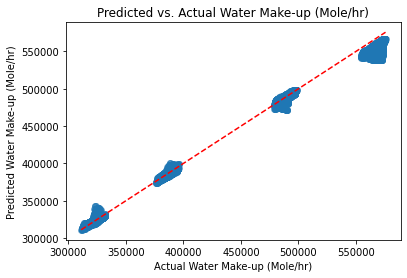

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test_original, y_pred, alpha=0.5)
plt.xlabel("Actual Water Make-up (Mole/hr)")
plt.ylabel("Predicted Water Make-up (Mole/hr)")
plt.title("Predicted vs. Actual Water Make-up (Mole/hr)")
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# Set plot style for a professional look
sns.set(style="whitegrid", palette="muted")

C:\Users\mostafa\AppData\Local\Temp\ipykernel_13280\1328164743.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(sc)


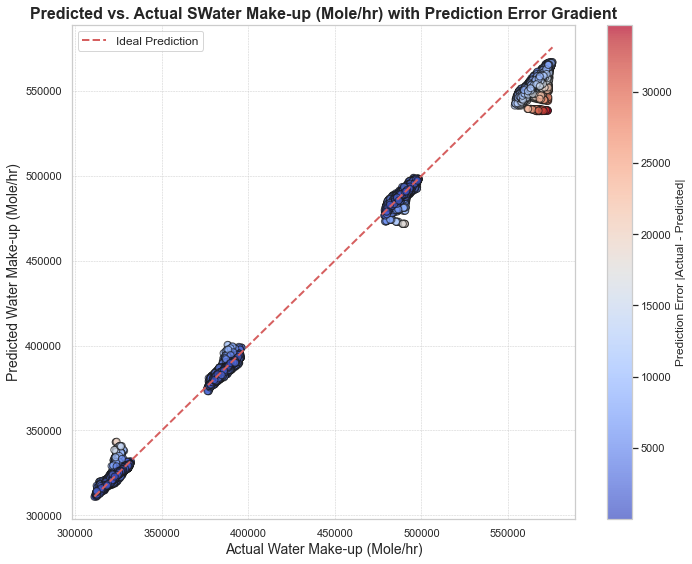

In [ ]:
# Set plot style for a professional look
sns.set(style="whitegrid", palette="muted")

# Set figure size and create a scatter plot with color gradient
plt.figure(figsize=(10, 8))
sc = plt.scatter(
    y_test_original, y_pred, 
    c=np.abs(y_pred - y_test_original), 
    cmap="coolwarm", s=50, alpha=0.7, edgecolor="k"
)

# Add color bar to indicate prediction error (absolute difference)
cbar = plt.colorbar(sc)
cbar.set_label("Prediction Error |Actual - Predicted|", fontsize=12)

# Plot a 1:1 line for reference
plt.plot(
    [y_test_original.min(), y_test_original.max()], 
    [y_test_original.min(), y_test_original.max()], 
    'r--', lw=2, label="Ideal Prediction"
)

# Set axis labels and title with enhanced font size
plt.xlabel("Actual Water Make-up (Mole/hr)", fontsize=14)
plt.ylabel("Predicted Water Make-up (Mole/hr)", fontsize=14)
plt.title("Predicted vs. Actual SWater Make-up (Mole/hr) with Prediction Error Gradient", fontsize=16, fontweight='bold')

# Customize legend and plot aesthetics
plt.legend(loc="upper left", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)

# Show plot
plt.tight_layout()
plt.show()

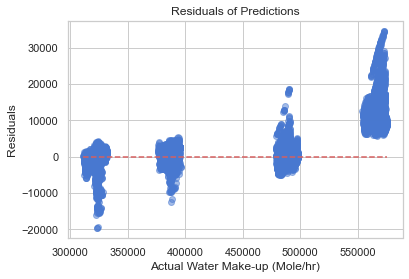

In [ ]:
residuals = y_test_original - y_pred
plt.scatter(y_test_original, residuals, alpha=0.5)
plt.hlines(0, y_test_original.min(), y_test_original.max(), colors='r', linestyles='dashed')
plt.xlabel("Actual Water Make-up (Mole/hr)")
plt.ylabel("Residuals")
plt.title("Residuals of Predictions")
plt.show()

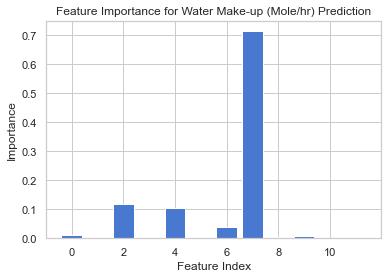

In [ ]:
feature_importances = 3.feature_importances_
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importance for Water Make-up (Mole/hr) Prediction")
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Example feature names (replace with actual feature names if available)
feature_names = ["C1 (Mass Fraction)", "C2 (Mass Fraction)","C3 (Mass Fraction)","IC4 (Mass Fraction)","NC4 (Mass Fraction)","N2 (Mass Fraction)","CO2 (Mass Fraction)","H2S (Mass Fraction)","NG Mass Flow (Kg/hr)","Reg Molar RR","HEX_T-HOT (C)","P-OUT (bar)"]

In [ ]:
# Feature importances from the model
feature_importances = model3.feature_importances_

In [ ]:
# Create a DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

In [ ]:
# Sort by importance for a more informative visualization
importance_df = importance_df.sort_values(by="Importance", ascending=True)

In [ ]:
# Set up a larger, more readable figure size
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")


<Figure size 720x576 with 0 Axes>

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

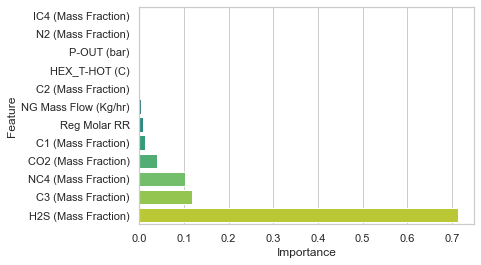

In [ ]:
# Horizontal bar plot
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")

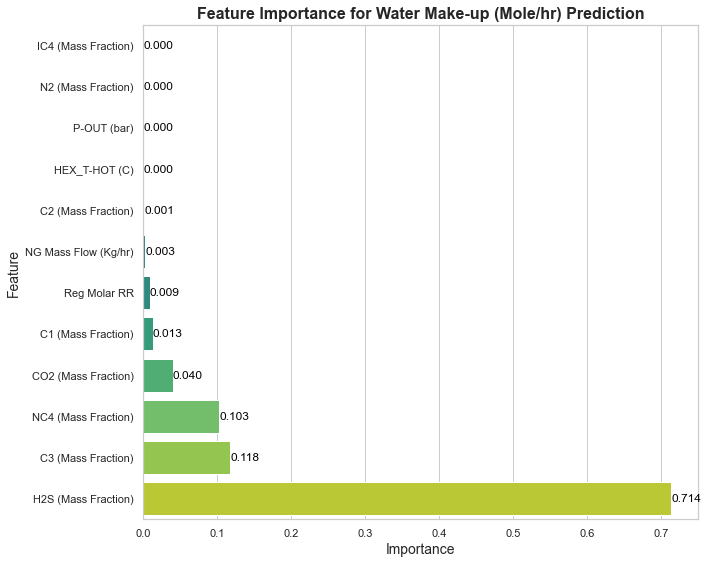

In [ ]:


# Create a DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance for a more informative visualization
importance_df = importance_df.sort_values(by="Importance", ascending=True)

# Set up a larger, more readable figure size
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

# Horizontal bar plot
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")

# Add title and labels
plt.title("Feature Importance for Water Make-up (Mole/hr) Prediction", fontsize=16, fontweight='bold')
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)

# Add data labels to each bar for clarity
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.3f}', color='black', ha="left", va="center")

plt.tight_layout()
plt.show()